In [36]:
import streamlit as st

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.metrics import mean_squared_error

from sklearn import set_config
set_config(display='diagram')

from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# Data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.drop(['Id'], axis=1, inplace=True)

In [4]:
print(' train :', train.shape)
print(' test :', test.shape)

 train : (1460, 80)
 test : (1459, 80)


In [5]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Reflexion

In [6]:
# prix moyen d'un appartement 180921 dollars
#train.SalePrice.describe()

## distribution

coefficient d'asymétrie:  1.5718291100676336


AttributeError: 'tuple' object has no attribute 'set_title'

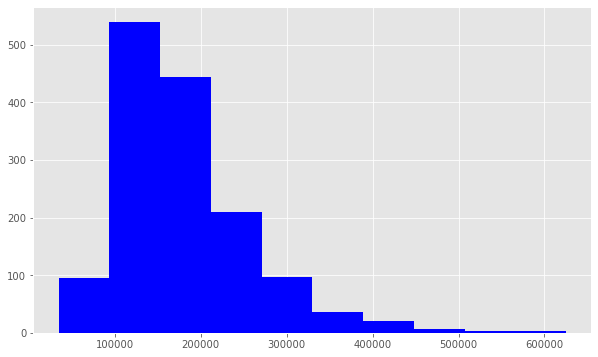

In [38]:
# si c'est asymétrique c'est bon si non je convertie en logarithmique
print("coefficient d'asymétrie: ", train.SalePrice.skew())
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize']=(10,6)
plt.hist(train.SalePrice,color='blue')
plt.show() #Positive asymmetry or to the right.

La valeur de y est :  0.12133506220520406


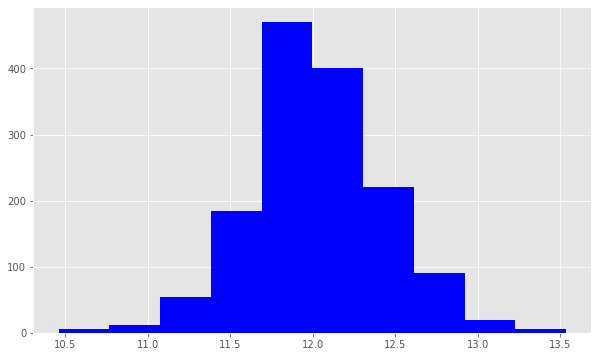

In [8]:
# ma target est log c'est bon
target=np.log(train.SalePrice)
print("La valeur de y est : ", target.skew())
plt.hist(target,color="blue")
plt.show()

## Outliers

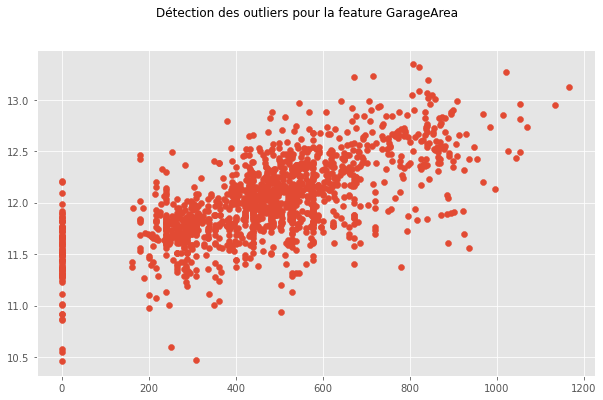

In [41]:
plt.scatter(x=train.GarageArea,y=np.log(train.SalePrice)) 
plt.suptitle("Détection des outliers pour la feature GarageArea")
plt.show()

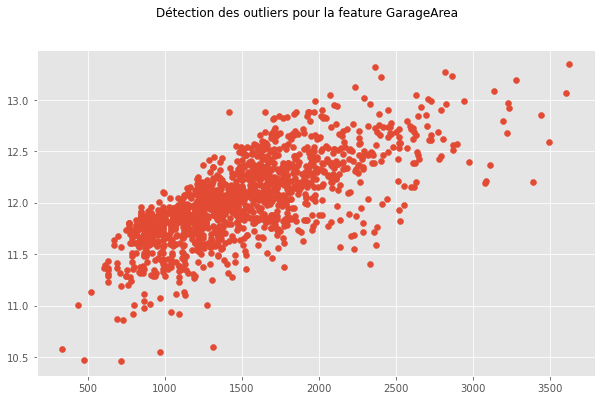

In [43]:
plt.scatter(x=train.GrLivArea,y=np.log(train.SalePrice))
plt.suptitle("Détection des outliers pour la feature GarageArea")
plt.show()

In [11]:
train=train[train.GarageArea <1200]
train=train[train.GrLivArea <4000]

## feature engenering

In [12]:
# Ajouter les zones d'habitation et la zone du sous-sol pour créer une nouvelle fonctionnalité TotArea
test["TotArea"] = test["GrLivArea"] + test["TotalBsmtSF"]
train["TotArea"] = train["GrLivArea"] + train["TotalBsmtSF"]

In [13]:
drop_col_test = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch']
test = test.drop(drop_col_test, axis=1)

In [14]:
drop_col_train = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch']
train = train.drop(drop_col_train, axis=1)

## Target and feature

In [15]:
X = train.drop(['SalePrice'], axis=1)
y = np.log(train.SalePrice)

### Choosing numerical and categorical

In [16]:
numeric_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

## Pipeline imputer - scaler - encoder

In [17]:
from sklearn.preprocessing import MinMaxScaler

numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'), MinMaxScaler())

categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                    OneHotEncoder(sparse=False, handle_unknown='ignore'))

## Pre - Processing on categorical and numerical 

In [18]:
transformer = make_column_transformer(
    (numerical_pipeline,numeric_features),
    (categorical_pipeline, categorical_features))

## choosing model and apply pre processing

In [19]:
#model = make_pipeline(transformer, Ridge())
#model

In [20]:
model = make_pipeline(transformer, RandomForestRegressor())
model



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12427cfd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12427cf70>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [21]:
# on construit les échantillons d'apprentissage et de validation
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
#X.columns


In [22]:
model.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12427cfd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12427cf70>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [23]:
model.score(X, y)

0.9824141703240784

In [26]:
X_test = test.drop(columns = 'Id')
preds = model.predict(X_test)
preds = np.exp(preds)

In [30]:
final_df = pd.DataFrame(test.Id)
#final_df

In [31]:
final_df['Saleprice'] = pd.DataFrame(preds)

In [32]:
final_df

,Id,Saleprice
0,1461,124403.442548
1,1462,158097.416446
2,1463,175708.467571
3,1464,180178.286608
4,1465,192159.677469
...,...,...
1454,2915,85906.445986
1455,2916,87218.721761
1456,2917,159127.471228
1457,2918,113455.458924


In [33]:
compression_opts = dict(method='zip',
                        archive_name='S.csv')  
final_df.to_csv('S.zip', index=False,
          compression=compression_opts) 